# Notebook Y: characterizing exoplanet heat transport with TIKE

# README

notebook is in a pretty solid place. all the code I want is there. I'd like to clean up the narrative significantly.


todo
- clean up the narrative

## Learning objectives

- apply inference techniques in the cloud
- understand how / when to use multiprocessing techniques

## Introduction
One of the great surprises of exoplanet atmospheres was the discovery of “hot Jupiters”: planets of Jupiter radius with orbital periods as short as less than one earth day. These planets orbit so close to their host stars that they are “spin-synchronized”: one side is eternal day, and the other eternal night. 
This setup leads to a particularly interesting question of atmospheric dynamics that we cannot study in our own solar system. Thus, studying the question of heat redistribution in hot Jupiters is important.

TESS, it turns out, is sensitive to the heat redistribution of the hottest of the transiting hot Jupiters — the so-called “ultra-hot Jupiters.” These planets are hot enough to emit appreciable amounts of visible light in the TESS band pass. These planets’ light curves over their full orbits — their *phase curves* — encode the logitudinal temperature distribution through the longitudinal brightness distribution.


This notebook will demonstrate how to fit the optical phase curves of an ultra-hot Jupiter. We will then relate these fits to underlying physical parameters to constrain the heat redistribution efficiency of this planet. By going through this process, we’ll see how to best optimize inference on TIKE. 



# 1. Import packages, set constants

Before diving into planet-finding, we will import some necessary packages.

- `astropy` contains a number of utility functions for working with astronomical data.
- `astroquery` lets us easily query the astronomical databases that contain the TESS lightcurves.
- `numpy` is used for array manipulation.
- `matplotlib.pyplot` is used to display images and plot datasets.
- `tqdm` is a lightweight progress bar that we can use to track how long our calculations will take.
- `pandas` let us interact easily with CSV files that we'll be downliading.
- `os` and `concurrent` let us make informed choiced when multithreading.

We'll want to `pip install` a specific vertsion of astroquery into our environment so that we can use some cloud techniques of interest.

**Note**: this installation will not persist after restarting TIKE. See the [installation instructions](~/references/tike_content-ref/markdown/software-installed.md) to do a persistent installation.

In [2]:
!pip install astroquery==0.4.8.dev9474

  Using cached astroquery-0.4.8.dev9474-py3-none-any.whl.metadata (7.3 kB)
Using cached astroquery-0.4.8.dev9474-py3-none-any.whl (5.4 MB)
  Attempting uninstall: astroquery
    Found existing installation: astroquery 0.4.8.dev9635
    Uninstalling astroquery-0.4.8.dev9635:
      Successfully uninstalled astroquery-0.4.8.dev9635


Let's check whether it installs correctly:

In [3]:
import astroquery
astroquery.__version__

'0.4.8.dev9474'

Great! Let's go ahead and import our other packages.

In [4]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.timeseries import BoxLeastSquares
from numba import njit


from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.exceptions import InvalidQueryError

from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from tqdm import tqdm

from multiprocessing import Pool


import os
from concurrent.futures import ThreadPoolExecutor, as_completed

We'll also make sure that we retrieve cloud files from AWS, making our data access stage much faster.

In [7]:
# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


# 2. Acquire lightcurves
For our purpose, we want to study a hot planet with a favorable signal. One such example is KELT-9b, which has been studied extensively through its TESS lightcurve. let’s access a number of lightcurves from this planet.


In [8]:
# download a single star from this catalog to inspect the data type we're working with.
TESS_table = Observations.query_criteria(objectname='KELT-9',
                                         obs_collection="TESS"
                                         , dataproduct_type='timeseries'
                                                 )

In [9]:
# Get associated science products for each Observation
data_products = Observations.get_product_list(TESS_table) 

# Keep only the science products
filtered = Observations.filter_products(data_products, productType="SCIENCE")

# Keep only the ones with our target's TICID
# there are multiple objects here. we want the TIC ID, which is in the obs_id.
mask = ['16740101' in obs_id for obs_id in filtered['obs_id']]
filtered_table = filtered[mask]

# Be selective about the columns we display
cols = ['obs_id', 'description', 'productSubGroupDescription']
# Filter for the light curve files; we don't need this now
lc_prod = Observations.filter_products(filtered_table
                                      , productSubGroupDescription = "LC")
lc_uri = Observations.get_cloud_uris(lc_prod)

Before we jump in and analyze the whole dataset at once, let's take a look at the lightcurve and see if we can pick out anything that pops out.

In [10]:
lc_fits = fits.open(lc_uri[0], use_fsspec=True, fsspec_kwargs={"anon": True})

In [11]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

(1685.0, 1689.0)

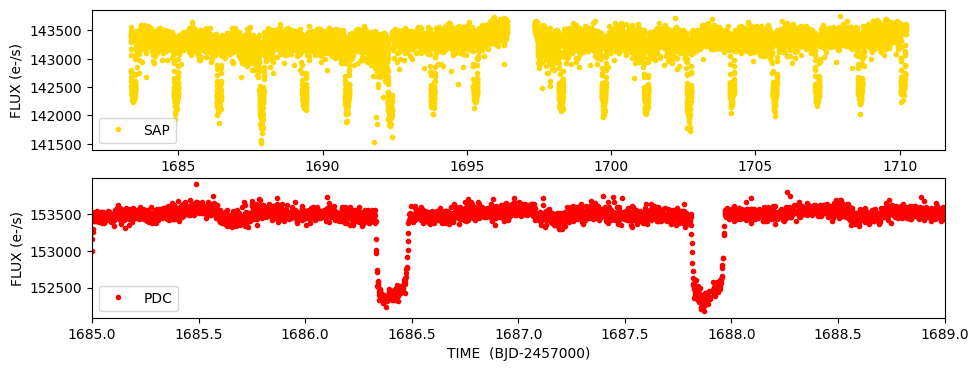

In [12]:
sapflux = lc['SAP_FLUX']
pdcflux = lc['PDCSAP_FLUX']
pdcflux_err = lc['PDCSAP_FLUX_ERR']
time_lc = lc['TIME']

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.xlim(1685, 1689)

Awesome! We can see the transits clearly by eye. We can also *maybe* see the secondary eclipse already.

Let's see if we can measure the planet's orbital period from this dataset to make sure we're looking at the right planet.

Question: punt some questions to the planet-finding notebook? or have this be self-contained?

In [13]:
time, flux, flux_err  = time_lc, pdcflux, pdcflux_err

# first, mask out NaNs
time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]

# set up the BoxLeastSquares algorithm to find the planet.
model = BoxLeastSquares(time, flux, flux_err)

In [14]:
lower_limit = 0.5 #days
upper_limit = 13 # days
n_periods_tested = 1000
periods = np.linspace(lower_limit, upper_limit, n_periods_tested)  # in units of days.

In [15]:
t_dur = 0.1

In [16]:
results = model.autopower(t_dur)  # The second argument is the duration of the transit (in days)

In [17]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 1.4818051948923852


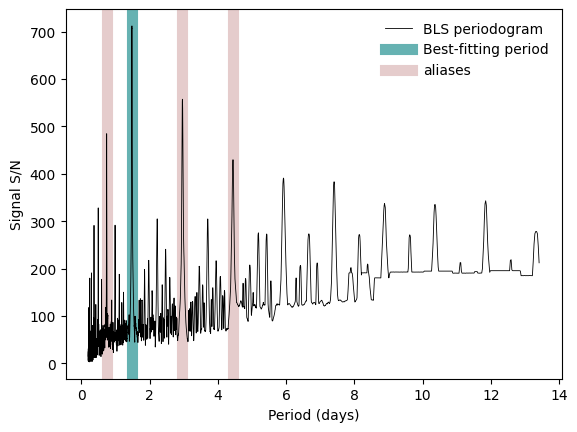

In [61]:
plt.plot(results.period, results.depth_snr, color='black', lw=.6, label='BLS periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Signal S/N')
plt.legend(frameon=False)

# highlight the best-fitting period
plt.axvline(1.4811235, color='teal', zorder=-1, lw=8, alpha=0.6, label='Best-fitting period')

# highlight a few aliases of that period, as well
plt.axvline(2 * 1.4811235, color='maroon', zorder=-1, lw=8, alpha=0.2, label='aliases')
plt.axvline(.5 * 1.4811235, color='maroon', zorder=-1, lw=8, alpha=0.2,)
plt.axvline(3 * 1.4811235, color='maroon', zorder=-1, lw=8, alpha=0.2,)
plt.legend(frameon=False)

Without any tuning, we found the planetary signal at the correct period. The next-strongest peaks in the periodogram are aliases of that period (multiples of that period with strong signal). That's excellent!

# Stitching the data together
We have all 6 lightcurves – that's a solid amount of data. Let's connect them all to each other.

In [20]:
joined_flux = []
joined_flux_err = []
joined_time = []

for uri in tqdm(lc_uri):
    lc_fits = fits.open(uri, use_fsspec=True, fsspec_kwargs={"anon": True})
    lc = lc_fits[1].data
    pdcflux = lc['PDCSAP_FLUX']
    pdcflux_err = lc['PDCSAP_FLUX_ERR']
    time_lc = lc['TIME']

    pdcflux = pdcflux[lc['quality'] == 0]
    pdcflux_err = pdcflux_err[lc['quality'] == 0]
    time_lc = time_lc[lc['quality'] == 0]

    joined_flux.append(pdcflux / np.nanmedian(pdcflux))
    joined_flux_err.append(pdcflux_err / np.nanmedian(pdcflux))
    joined_time.append(time_lc)

joined_flux = np.concatenate(joined_flux)
joined_flux_err = np.concatenate(joined_flux_err)
joined_time = np.concatenate(joined_time)

100%|██████████| 6/6 [00:00<00:00,  8.44it/s]


We have all the data together — woohoo! Let's filter out all the NaNs.

Because we joined many datasets together, let's make sure everything is ordered in time.

In [21]:
sorted_indices = np.argsort(joined_time)
joined_flux = joined_flux[sorted_indices]
joined_flux_err = joined_flux_err[sorted_indices]
joined_time = joined_time[sorted_indices]

And let's check that the time is always increasing:

In [22]:
np.all(np.diff(joined_time) >= 0)

True

Great! Let's plot up our combined dataset.

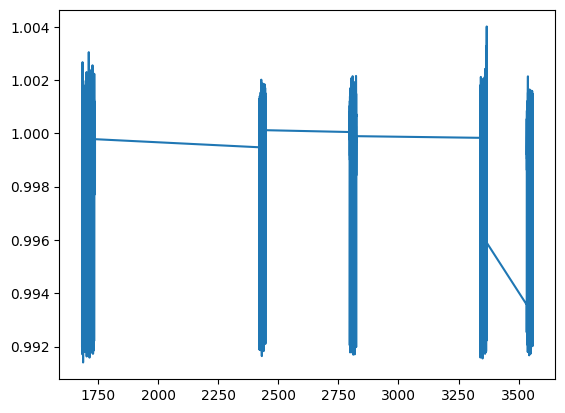

In [23]:
plt.plot(joined_time, joined_flux)
# plt.xlim(np.min(joined_time), np.min(joined_time) + 2)

It's even harder to see things by eye! Let's phase-fold on the known period.

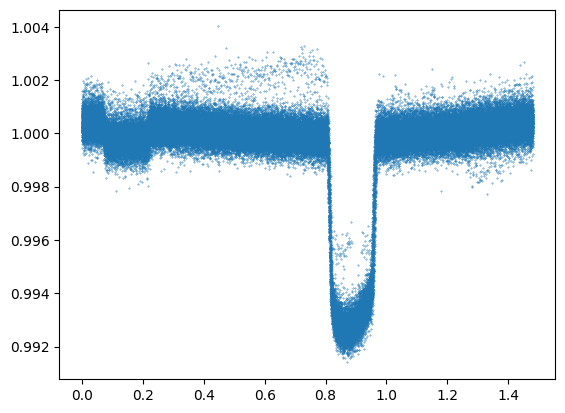

In [24]:
period = 1.4811235
x = joined_time % period
plt.scatter(x, joined_flux, s=0.1)

Now, both the transit and the secondary eclipse look very clear. Great!

Because we're tracking just the planetary *emission*, we now want to mask out the transit.

In [25]:
# now we want to mask out the transits. because that's not part of the planet emission

In [26]:
t_transit = 2458955.970923 # from exoplanet archive
half_duration = 3.9158/24/2 # convert to days

transit_times = t_transit + 0.5 * period * np.arange(-600,4000)

# Create mask for your time array
mask = np.ones(len(joined_time), dtype=bool)  # Start with all True

time_array = joined_time + 2457000

# Mask out points within ±half_duration of each transit
for t0 in transit_times:
    in_transit = (time_array >= t0 - half_duration) & (time_array <= t0 + half_duration)
    mask[in_transit] = False



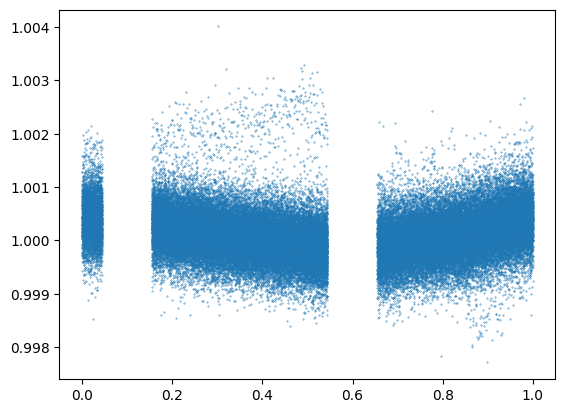

In [27]:
period = 1.4811235
# transit is masked out!
x = (joined_time[mask] % period) / period
plt.scatter(x, joined_flux[mask], s=0.1)

# Fit a sinusoid to the data

In [28]:
# ok we want to fit things

In [29]:
a_min = 1-0.05
a_max = 1 + 0.05
a_guess = 1.

b_min = -6
b_max = 0
b_guess = -3.5

d_min = -np.pi
d_max = np.pi
d_guess = 0.7 * np.pi/2

log_f_min = -10.
log_f_max = 1.
log_f_guess = 0.1

In [30]:
@njit
def calc_sinusoid(x, a, b, d):
    """
    Calculates a sinusoid in the most general form, including an offset.

    x is in orbital phase already.
    """
    b = np.power(10., b) 
    sinusoid = a + b * np.sin(2 * np.pi * x + d)
    return sinusoid

In [31]:
@njit
def log_likelihood(theta, x, y, yerr):
    a,b,d, log_f = theta
    model = calc_sinusoid(x, a, b,  d)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [32]:
# now fit
np.random.seed(42)
x = (joined_time[mask] % period)/period
y = joined_flux[mask]
yerr = joined_flux_err[mask]
nll = lambda *args: -log_likelihood(*args)


initial = np.array([a_guess, b_guess, d_guess,
                   log_f_guess])


soln = minimize(nll, initial, args=(x, y, yerr),
               bounds=((a_min, a_max),
                       (b_min, b_max),
                       (d_min, d_max),
                      (log_f_min, log_f_max))
               )
a_ml,b_ml,d_ml, log_f_ml = soln.x


In [33]:
a_ml,b_ml,d_ml

(1.000117018480015, -3.5941514375534034, 1.075382304708873)

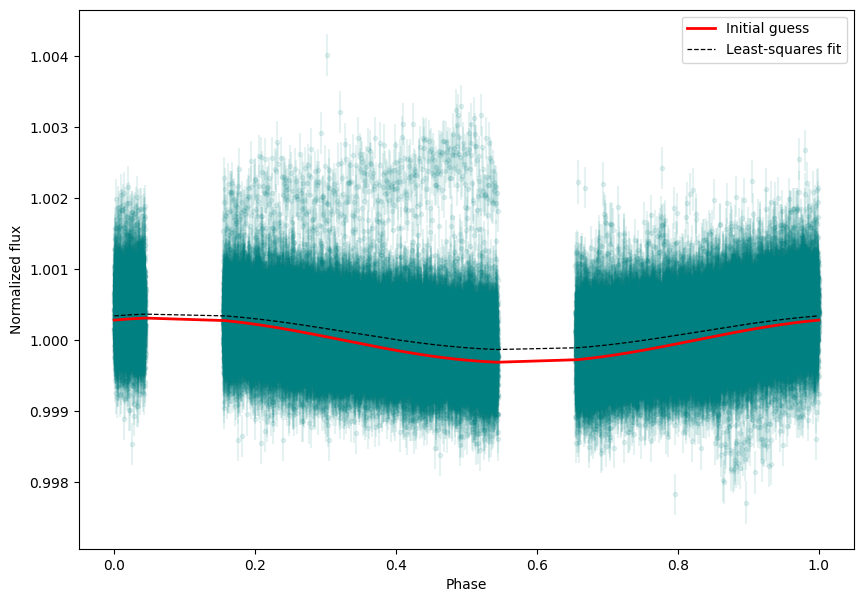

In [64]:

# plt.plot(joined_time[mask], eclipse_model[mask], color='black', zorder=1)
# plt.ylim(.997, 1.02)
# plt.xlim(1730, 1735)


plt.figure(figsize=(10,7))
plt.plot(np.sort(x), calc_sinusoid(np.sort(x), a_guess, b_guess, d_guess), "red", alpha=1, lw=2, label='Initial guess')
plt.plot(np.sort(x), calc_sinusoid(np.sort(x), a_ml,b_ml,d_ml), zorder=20, color='black', lw=.9, linestyle='--',
        label='Least-squares fit')
plt.errorbar(x, y, yerr, fmt='.', zorder=-1, alpha=0.1, color='teal')

plt.xlabel('Phase')
plt.ylabel('Normalized flux')

plt.legend()

# MCMC inference on TIKE

Now we’ve calculated the best-fitting sinusoid for this dataset. We haven’t, however, done what was promised — Bayesian inference. Doing so will allow us to quantify the *uncertainty* on the best fit parameters, not just the best fit alone.

First, let’s dive a bit more into what’s required to do Bayesian inference. Bayes theorem is as follows:

Where __ is the posterior probability (our understanding after the calculation), __ is the prior probability (our understanding before the calculation), __ is the likelihood function from above, and ___ is the evidence (a normalization factor we can ignore for this notebook). Bayes theorem essentially says that we “update” our knowledge (the prior) using the model and the data together (the likelihood) to arrive at updated understanding. Side note: this was Bayes trying to put into mathematics how we update our intuition in the world: we see new things, and those things change our minds about previous things.

So let’s go ahead and define the functions that we’ll need. Let’s start with a prior. What do we know about the values of our variables (a, b, d, log_f) before performing our experiment? You may think that we don’t know much, but we do have the ranges that we passed to scipy optimize minimize. These ranges constitute “uniform priors”: ranges of values that are equally likely to the best of our knowledge before seeing the data. So, we want to reject every value outside these ranges, and otherwise not really do anything.

As with the likelihood, we’ll use the log prior instead of the prior directly to make things easier numerically. And also as with the likelihood, let’s njit this function to accelerate it.


In [35]:
# we have a best-fit model! now let's MCMC it :D

In [36]:
@njit
def log_prior(theta):
    a, b, d, log_f = theta
    
    # Check if parameters are within bounds
    if (a_min <= a <= a_max and
        b_min <= b <= b_max and
        d_min <= d <= d_max and
        log_f_min <= log_f <= log_f_max):
        return 0.0  # log(1) = 0, uniform prior within bounds
    
    return -np.inf  # log(0) = -inf, zero probability outside bounds

Great! Now we need to define our log posterior function. The posterior multiplies the prior and the likelihood, per Bayes Theorem. For our log quantities, we instead *add* the two. We can also catch values that are rejected from our prior so that we can move onward without calculating the likelihood of those “bad” values.

In [37]:
@njit
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Great! We have a log posterior distribution. Let’s calculate a few values (todo: do this a bit.)

In [38]:
log_probability

CPUDispatcher(<function log_probability at 0x7f7c476d18a0>)

AN issue might already be apparent: how do we get a sense of the distribution of log posterior values with respect to each of the parameters, and the correlations between these parameters? It would take a very, very long time to do this manually. Automating the process by looping over all possible input values is another option, but that is inefficient and would take the *computer* a very long time to calculate. 


There is another option that is better yet — cleverly *sampling* the posterior distribution. That is, instead of trying all values, just calculating a lot of values near the peak(s) of the posterior function. That will tell us our answer without testing all possible input values.


One such sampler is the popular emcee package (link). We’ll give it our probability function, tell it how many times it should evaluate our function, and it’ll efficiently explore the posterior distribution in a statistically robust way.

It uses a number of independent *chains* to do so. Let’s use a standard number of chains (32). We can initialize our chains near the best fit solution, but with slight randomness in between them so that each of the chains explore the parameter space differently.


Let’s try running the sampler a few times to estimate its runtime.


In [68]:
guess_arr = np.array([a_guess, b_guess, d_guess, log_f_guess])
# pos = soln.x + 1e-8 * np.random.randn(32, 5)
pos = guess_arr + 1e-8 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 150, progress=True);



100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Not too bad — can we do better? We can use the multiprocessing approach introduced in other notebooks to potentially speed up our posterior distribution sampling. As elsewhere, we’ll use 4 independent processes to split up our work.


In [69]:
ncores = 4  # Adjust this based on your CPU

# Create the pool of workers
with Pool(ncores) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, 
        args=(x, y, yerr),
        pool=pool  # Add the pool parameter
    )
    sampler.run_mcmc(pos, 150, progress=True)

100%|██████████| 150/150 [00:18<00:00,  8.20it/s]


Wait —- this is slower! What gives?

Let’s think a bit more about what multiprocessing is doing. It’s splitting up the work, but it’s also coordinating between the cores — eg, joining their results at the end. For computations that are already quite efficient (like our posterior distribution), it can actually take more time to do this coordination that to do the actual calculation of interest. This all goes to show that more cores aren’t always better, and that each problem needs to be checked to see if it will benefit from multiprocessing.

Let’s go back to serial processing and run a full chain — maybe 5000 steps.


In [40]:
guess_arr = np.array([a_guess, b_guess, d_guess, log_f_guess])
# pos = soln.x + 1e-8 * np.random.randn(32, 5)
pos = guess_arr + 1e-8 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);



100%|██████████| 5000/5000 [05:29<00:00, 15.19it/s]


Well, if completed. How do we know that it did what we wanted? The first step is to visualize the chains to check whether they have explored parameter space before converging.


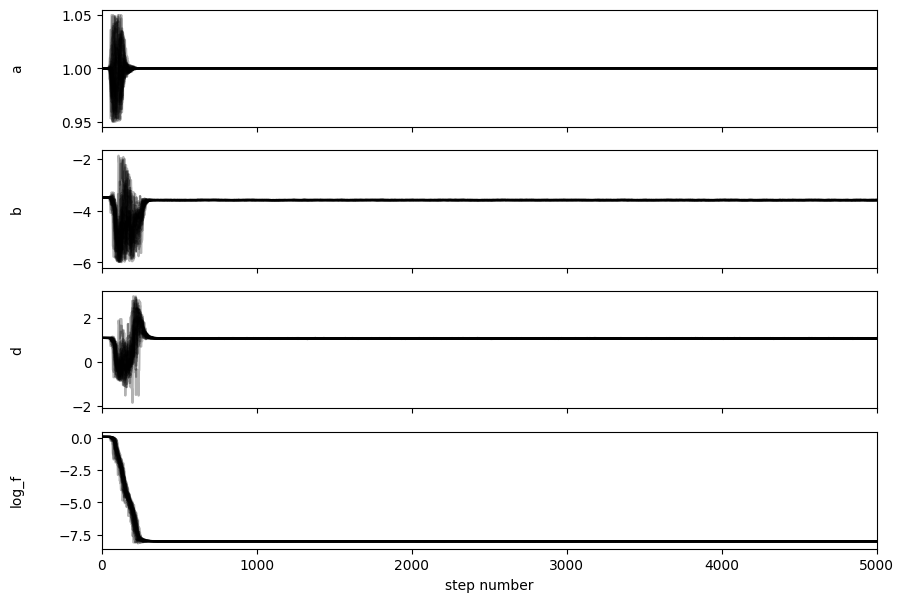

In [41]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "d", "log_f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Yes! It looks like the walkers started in a small ball near the initial guess, explored a wide range of possible input values, then settled down on a much narrower range of values. This latter range is the distribution of values that is likely given the model, data, and priors.


Let’s cut the chain down a bit. This is for two reasons: 1) we want a more manageable chain to visualize, and 2) not every step in a chain is an independent sample. Because of the algorithm used by emcee, neighboring steps within a certain correlation length can be correlated with one another. To estimate some independent samples, we can thin and get the thing. Let's discard the first 1000 samples --- this very clearly avoids the "burn-in" phase.


In [42]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 28.17573138 110.42035171  40.05545056 188.20656462]

In [44]:
flat_samples = sampler.get_chain(discard=1000, thin=100, flat=True)
print(flat_samples.shape)

(1280, 4)


Now that we have a more representative chain, let’s visualize it. We can do so with the corner package, which will show the marginal distributions (the probabilities of each individual parameter) and the correlations between each pair of parameters.


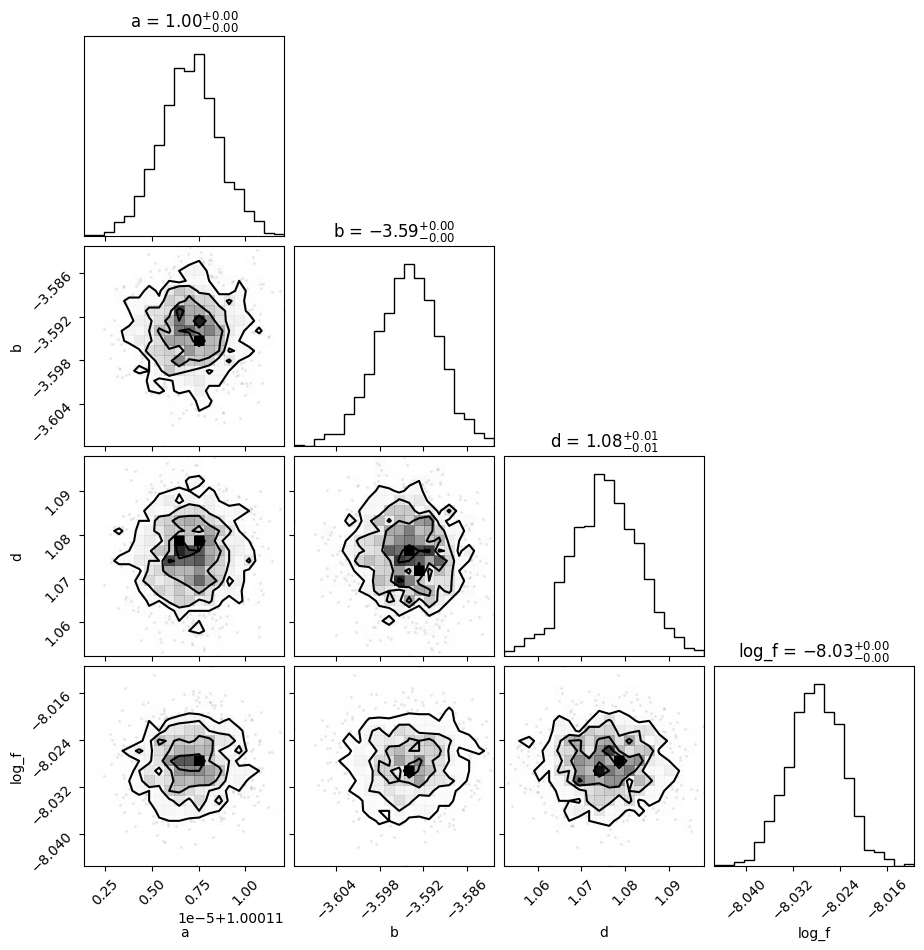

In [45]:
truths=[1, 0.001 ,-7.3, -7]
fig = corner.corner(
    flat_samples, labels=labels,show_titles=True,truths=truths
);

We see that each of these parameters has roughly Gaussian marginal posteriors. This. Is good — it means that there really is one “best” value for each of these parameters.

We also don’t see and strong correlations (highly ellipsoidal or banana-shaped) correlations off the top row. This is also good — it means our understanding of one parameter doesn’t depend too much on the others. 


This plot is a great diagnostic, and it implies that our solution is very tightly constrained, but it’s still hard to parse what this means for the lightxuve. Let’s plot up a bunch of samples from the posterior distribution on top of the data.


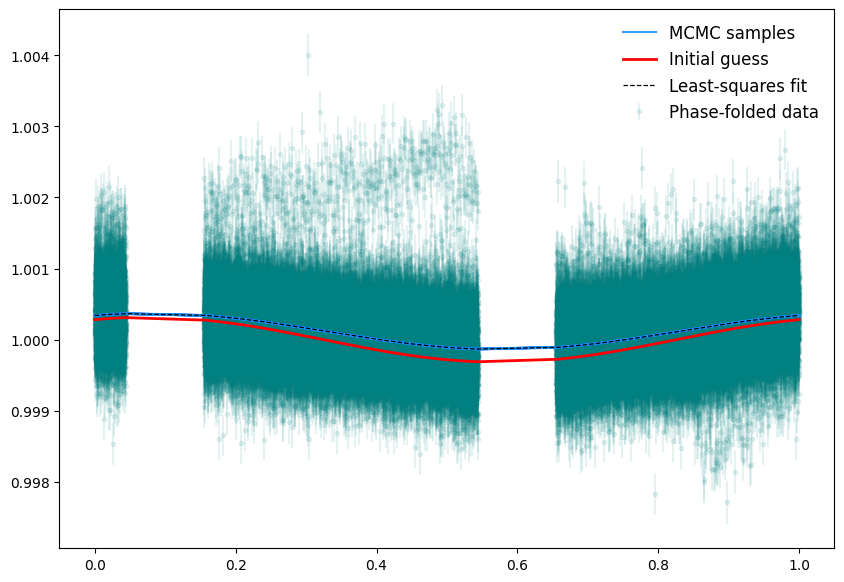

In [47]:
plt.figure(figsize=(10,7))

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind][:-1]
    plt.plot(np.sort(x), calc_sinusoid(np.sort(x), *sample), "dodgerblue", alpha=0.1)
plt.plot(np.sort(x), calc_sinusoid(np.sort(x), *sample), "dodgerblue", alpha=0.9, label='MCMC samples')

# plt.plot(joined_time%period, calc_sinusoid(joined_time, a_guess, b_guess, 0.7 * np.pi/2), "black", alpha=1, lw=2)
plt.errorbar(x, y, yerr, fmt='.', zorder=-1, alpha=0.1, color='teal', label='Phase-folded data')
plt.plot(np.sort(x), calc_sinusoid(np.sort(x), a_guess, b_guess, d_guess), "red", alpha=1, lw=2,
        label='Initial guess')
plt.plot(np.sort(x), calc_sinusoid(np.sort(x), a_ml,b_ml,d_ml), zorder=20, color='black', lw=.9, linestyle='--',
        label='Least-squares fit')

plt.legend(fontsize=12, frameon=False)
# plt.plot(joined_time[mask], eclipse_model[mask], color='black', zorder=1)
# plt.ylim(.997, 1.02)
# plt.xlim(1730, 1735)

Wow! Our solution is really tightly constrained. This is the power of having access to so much data. All of our samples (orange) appear to lie on top of one another.

Also note that our MCMC least-squares fit lies almost right in the middle of our MCMC fit.


Extensions of this work could be to apply a more sophisticated model (cite paper), try a different planet (like blah), or something else!